# Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# sklearn
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.impute import KNNImputer
from sklearn.preprocessing import RobustScaler, OneHotEncoder, FunctionTransformer
from sklearn.metrics import classification_report
## estimators
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import (RandomForestClassifier,
                              HistGradientBoostingClassifier,
                              BaggingClassifier,
                              AdaBoostClassifier)
from xgboost import XGBClassifier


from titanic_challenge.kaggle import interface

# Titanic challenge - kaggle

# Baseline

## Load data

In [4]:
df = pd.read_csv("../data/train.csv")
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
df.set_index("PassengerId", inplace=True)

In [6]:
df.duplicated().sum()

0

In [7]:
round(df.isnull().sum().sort_values(ascending=False)/len(df)*100)

Cabin       77.0
Age         20.0
Embarked     0.0
Survived     0.0
Pclass       0.0
Name         0.0
Sex          0.0
SibSp        0.0
Parch        0.0
Ticket       0.0
Fare         0.0
dtype: float64

## Handling missing data

In [8]:
# drop Cabin
df.drop(columns=["Cabin"], inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(4)
memory usage: 76.6+ KB


## Train test split

In [9]:
X = df.drop(columns="Survived")
y = df["Survived"]

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
X_train.shape, y_train.shape

((712, 9), (712,))

## Numerical columns

In [11]:
num_cols = ["Age", "Fare"]

In [12]:
num_transformer = make_pipeline(
    KNNImputer(),
    RobustScaler()
)
num_transformer

Pipeline(steps=[('knnimputer', KNNImputer()), ('robustscaler', RobustScaler())])

## Categorical columns

In [13]:
cat_cols = ["Pclass", "Sex", "SibSp", "Parch", "Embarked"]
cat_cols

['Pclass', 'Sex', 'SibSp', 'Parch', 'Embarked']

In [14]:
X[cat_cols].head(1)

,Pclass,Sex,SibSp,Parch,Embarked
PassengerId,,,,,
1,3,male,1,0,S


In [15]:
cat_transformer = make_pipeline(
    OneHotEncoder(sparse_output=False, handle_unknown="ignore", drop="if_binary")
)
cat_transformer

Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(drop='if_binary', handle_unknown='ignore',
                               sparse_output=False))])

## Basic preproc

In [16]:
basic_preproc = make_column_transformer(
    (num_transformer, num_cols),
    (cat_transformer, cat_cols),
    remainder="drop"
)
basic_preproc

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('knnimputer', KNNImputer()),
                                                 ('robustscaler',
                                                  RobustScaler())]),
                                 ['Age', 'Fare']),
                                ('pipeline-2',
                                 Pipeline(steps=[('onehotencoder',
                                                  OneHotEncoder(drop='if_binary',
                                                                handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 ['Pclass', 'Sex', 'SibSp', 'Parch',
                                  'Embarked'])])

## Baseline

In [17]:
baseline_pipe = make_pipeline(
    basic_preproc,
    LogisticRegression(max_iter=1000, solver="lbfgs")
)
baseline_pipe

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('knnimputer',
                                                                   KNNImputer()),
                                                                  ('robustscaler',
                                                                   RobustScaler())]),
                                                  ['Age', 'Fare']),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(drop='if_binary',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['Pclass', 'Sex', 'SibSp',
                                                   'Parch', 'Embarked'])])),
                ('logisticregression', LogisticRegression(max_iter=1000))])

In [18]:
cross_val_score(baseline_pipe, X_train, y_train).mean()

/home/adbla/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


0.8075051708854526

In [19]:
baseline_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('knnimputer',
                                                                   KNNImputer()),
                                                                  ('robustscaler',
                                                                   RobustScaler())]),
                                                  ['Age', 'Fare']),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(drop='if_binary',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['Pclass', 'Sex', 'SibSp',
                                                   'Parch', 'Embarked'])])),
                ('logisticregression', LogisticRegression(max_iter=1000))])

In [18]:
y_pred = baseline_pipe.predict(X_test)

In [19]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.88      0.87       110
           1       0.81      0.78      0.79        69

    accuracy                           0.84       179
   macro avg       0.84      0.83      0.83       179
weighted avg       0.84      0.84      0.84       179



## First submission

In [20]:
test_df = pd.read_csv("../data/test.csv")
test_df.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [21]:
y_pred = baseline_pipe.predict(test_df)

/home/adbla/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [59]:
submission_df = pd.DataFrame({"Survived": y_pred}, index=test_df.PassengerId)
submission_df.head()

,Survived
PassengerId,
892,0
893,0
894,0
895,0
896,1


In [23]:
from datetime import datetime

file_name = f"""sub_{datetime.today().strftime("%d-%m-%Y@%H:%M:%S")}.csv"""
file_name

'sub_10-07-2024@10:19:00.csv'

In [24]:
submission_df.set_index("PassengerId", inplace=True)

In [25]:
submission_df.to_csv(f"../data/submissions/{file_name}")

## SCORE : 0.77

# Finetuning preprocessign

In [20]:
num_cols

['Age', 'Fare']

<AxesSubplot:xlabel='Fare', ylabel='Count'>

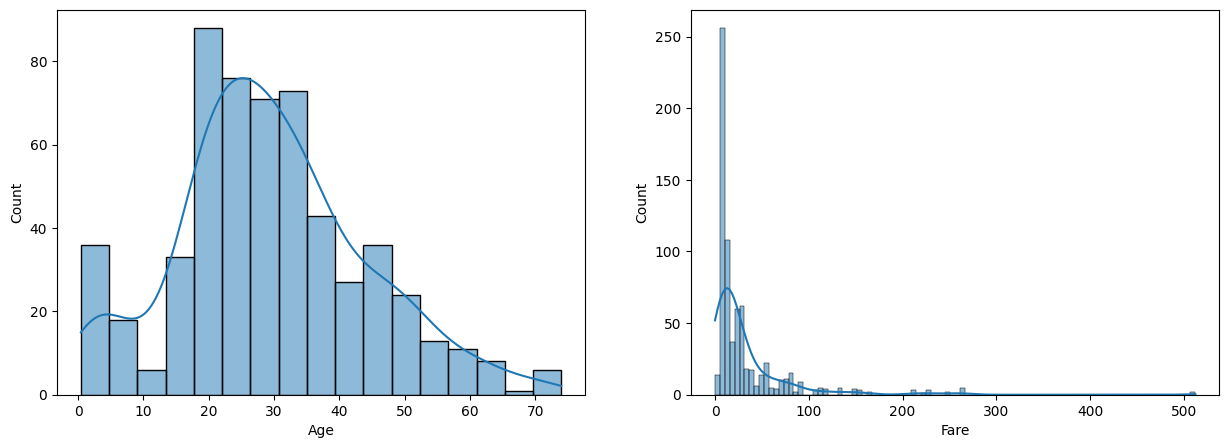

In [21]:
fig, axs = plt.subplots(1, 2, figsize=(15,5))

sns.histplot(X_train.Age, kde=True, ax=axs[0])
sns.histplot(X_train.Fare, kde=True, ax=axs[1])

In [22]:
X.Name.str.extract(r".*,\ (\w*)\.\s").value_counts()

Mr          517
Miss        182
Mrs         125
Master       40
Dr            7
Rev           6
Col           2
Major         2
Mlle          2
Capt          1
Don           1
Jonkheer      1
Lady          1
Mme           1
Ms            1
Sir           1
dtype: int64

* Miss : unmarried woman
* Master : under 18 male
* Mrs : married woman
* Rev : priest
* Major : under colonel
* Mlle : same as Miss
* Col : senior rank
* Don : same as mister
* Mme : same as Mrs
* Ms : same as Miss
* Lady : same as Mrs
* Sir : same as Mr
* Jonkheer : same as Mr
* Capt : same as Mr

In [23]:
titles_simplified = {
    "Mr":"Mr",
    "Miss":"Miss",
    "Mrs":"Mrs",
    "Master":"Master",
    "Dr":"Mr",
    "Rev":"Mr",
    "Major":"Mr",
    "Mlle":"Miss",
    "Col":"Mr",
    "Don":"Mr",
    "Mme":"Mrs",
    "Ms":"Mrs",
    "Lady":"Mrs",
    "Sir":"Mr",
    "Capt":"Mr",
    "Jonkheer":"Mr",
    "the Countess": "Mrs"
}

def extract_title(df):
    df["Title"] = df.Name.str.extract(r".*,\ (\w*\s?\w*)\.\s")
    df["Title"].replace(titles_simplified, inplace=True)
    df["Age"] = df.groupby("Title")["Age"].transform(lambda group : group.fillna(group.median()))
    return df

title_extractor = FunctionTransformer(extract_title)
title_extractor

FunctionTransformer(func=<function extract_title at 0x7fa03f739cf0>)

In [24]:
custom_age_transformer = make_pipeline(
    title_extractor
)
custom_age_transformer

Pipeline(steps=[('functiontransformer',
                 FunctionTransformer(func=<function extract_title at 0x7fa03f739cf0>))])

In [25]:
num_transformer = make_pipeline(
    KNNImputer(),
    RobustScaler()
)
num_transformer

Pipeline(steps=[('knnimputer', KNNImputer()), ('robustscaler', RobustScaler())])

In [26]:
preproc = make_column_transformer(
    (num_transformer, num_cols),
    (cat_transformer, cat_cols),
    remainder="drop"
)
preproc

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('knnimputer', KNNImputer()),
                                                 ('robustscaler',
                                                  RobustScaler())]),
                                 ['Age', 'Fare']),
                                ('pipeline-2',
                                 Pipeline(steps=[('onehotencoder',
                                                  OneHotEncoder(drop='if_binary',
                                                                handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 ['Pclass', 'Sex', 'SibSp', 'Parch',
                                  'Embarked'])])

In [27]:
pipeline = make_pipeline(
    title_extractor,
    preproc,
    LogisticRegression(max_iter=1000, solver="lbfgs")
)
pipeline

Pipeline(steps=[('functiontransformer',
                 FunctionTransformer(func=<function extract_title at 0x7fa03f739cf0>)),
                ('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('knnimputer',
                                                                   KNNImputer()),
                                                                  ('robustscaler',
                                                                   RobustScaler())]),
                                                  ['Age', 'Fare']),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(drop='if_binary',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['Pclass', 'Sex', 'SibSp',
                                                   'Parch', 'Embarked'])])),
                ('logisticregression', LogisticRegression(max_iter=1000))])

In [28]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('functiontransformer',
                 FunctionTransformer(func=<function extract_title at 0x7fa03f739cf0>)),
                ('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('knnimputer',
                                                                   KNNImputer()),
                                                                  ('robustscaler',
                                                                   RobustScaler())]),
                                                  ['Age', 'Fare']),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(drop='if_binary',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['Pclass', 'Sex', 'SibSp',
                                                   'Parch', 'Embarked'])])),
                ('logisticregression', LogisticRegression(max_iter=1000))])

In [29]:
cross_val_score(pipeline, X_test, y_test).mean()

/home/adbla/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


0.7938095238095239

In [30]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('functiontransformer',
                 FunctionTransformer(func=<function extract_title at 0x7fa03f739cf0>)),
                ('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('knnimputer',
                                                                   KNNImputer()),
                                                                  ('robustscaler',
                                                                   RobustScaler())]),
                                                  ['Age', 'Fare']),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(drop='if_binary',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['Pclass', 'Sex', 'SibSp',
                                                   'Parch', 'Embarked'])])),
                ('logisticregression', LogisticRegression(max_iter=1000))])

In [32]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 179 entries, 440 to 736
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    179 non-null    int64  
 1   Name      179 non-null    object 
 2   Sex       179 non-null    object 
 3   Age       144 non-null    float64
 4   SibSp     179 non-null    int64  
 5   Parch     179 non-null    int64  
 6   Ticket    179 non-null    object 
 7   Fare      179 non-null    float64
 8   Embarked  179 non-null    object 
dtypes: float64(2), int64(3), object(4)
memory usage: 14.0+ KB


In [33]:
pipeline.predict(X_test)

array([0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0,
       1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0,
       0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1,
       1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1,
       1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0,
       0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0,
       1, 1, 0])

In [34]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 179 entries, 440 to 736
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    179 non-null    int64  
 1   Name      179 non-null    object 
 2   Sex       179 non-null    object 
 3   Age       179 non-null    float64
 4   SibSp     179 non-null    int64  
 5   Parch     179 non-null    int64  
 6   Ticket    179 non-null    object 
 7   Fare      179 non-null    float64
 8   Embarked  179 non-null    object 
 9   Title     179 non-null    object 
dtypes: float64(2), int64(3), object(5)
memory usage: 15.4+ KB


In [35]:
test_df.info()

NameError: name 'test_df' is not defined

In [36]:
cross_val_score(pipeline, X_test, y_test).mean()

/home/adbla/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


0.8050793650793651

In [37]:
pipeline

Pipeline(steps=[('functiontransformer',
                 FunctionTransformer(func=<function extract_title at 0x7fa03f739cf0>)),
                ('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('knnimputer',
                                                                   KNNImputer()),
                                                                  ('robustscaler',
                                                                   RobustScaler())]),
                                                  ['Age', 'Fare']),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(drop='if_binary',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['Pclass', 'Sex', 'SibSp',
                                                   'Parch', 'Embarked'])])),
                ('logisticregression', LogisticRegression(max_iter=1000))])

In [38]:
y_pred = pipeline.predict(test_df)

NameError: name 'test_df' is not defined

In [46]:
submission_df = pd.DataFrame({"PassengerId": test_df.PassengerId, "Survived": y_pred})
submission_df.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1


In [47]:
submission_df.set_index("PassengerId", inplace=True)

In [48]:
from datetime import datetime

file_name = f"""sub_{datetime.today().strftime("%d-%m-%Y@%H:%M:%S")}.csv"""
file_name

'sub_10-07-2024@10:20:26.csv'

In [49]:
submission_df.to_csv(f"../data/submissions/{file_name}")

## reusing old pipeline on new dataset (old imputer won't do anything)

In [113]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train.shape, y_train.shape

((712, 10), (712,))

In [115]:
cross_val_score(baseline_pipe, X_train, y_train).mean()

/home/adbla/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


0.8020486555697823

In [116]:
baseline_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('knnimputer',
                                                                   KNNImputer()),
                                                                  ('robustscaler',
                                                                   RobustScaler())]),
                                                  ['Age', 'Fare']),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(drop='if_binary',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['Pclass', 'Sex', 'SibSp',
                                                   'Parch', 'Embarked'])])),
                ('logisticregression', LogisticRegression(max_iter=1000))])

In [121]:
y_pred = baseline_pipe.predict(X_test)
y_pred

array([0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1,
       0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1,
       1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1,
       0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0,
       0, 1, 0])

In [123]:
y_test

PassengerId
566    0
161    0
554    1
861    0
242    1
      ..
881    1
92     0
884    0
474    1
638    0
Name: Survived, Length: 179, dtype: int64

In [126]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.89      0.84       110
           1       0.79      0.65      0.71        69

    accuracy                           0.80       179
   macro avg       0.80      0.77      0.78       179
weighted avg       0.80      0.80      0.79       179



In [127]:
num_transformer

Pipeline(steps=[('knnimputer', KNNImputer()), ('robustscaler', RobustScaler())])

# Finding a better estimator

In [42]:
classifiers = [
    LogisticRegression(max_iter=1000, solver="lbfgs"),
    SVC(),
    RandomForestClassifier(),
    HistGradientBoostingClassifier(),
    BaggingClassifier(),
    AdaBoostClassifier()
]

In [43]:
classifier = classifiers[0]

In [44]:
basic_preproc

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('knnimputer', KNNImputer()),
                                                 ('robustscaler',
                                                  RobustScaler())]),
                                 ['Age', 'Fare']),
                                ('pipeline-2',
                                 Pipeline(steps=[('onehotencoder',
                                                  OneHotEncoder(drop='if_binary',
                                                                handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 ['Pclass', 'Sex', 'SibSp', 'Parch',
                                  'Embarked'])])

In [60]:
preproc

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('knnimputer', KNNImputer()),
                                                 ('robustscaler',
                                                  RobustScaler())]),
                                 ['Age', 'Fare']),
                                ('pipeline-2',
                                 Pipeline(steps=[('onehotencoder',
                                                  OneHotEncoder(drop='if_binary',
                                                                handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 ['Pclass', 'Sex', 'SibSp', 'Parch',
                                  'Embarked'])])

In [45]:
res = {
    "classifier": [],
    "score": []
}

for classifier in classifiers:
    pipeline = make_pipeline(
        title_extractor,
        preproc,
        classifier
    )
    res["classifier"].append(str(classifier).split("(")[0])
    res["score"].append(cross_val_score(pipeline, X_train, y_train).mean())
res

/home/adbla/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/adbla/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/adbla/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/adbla/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be en

{'classifier': ['LogisticRegression',
  'SVC',
  'RandomForestClassifier',
  'HistGradientBoostingClassifier',
  'BaggingClassifier',
  'AdaBoostClassifier'],
 'score': [0.8089234708953018,
  0.8201516793066089,
  0.7948783610755441,
  0.8075248694967005,
  0.7990938638825963,
  0.8047572146163697]}

In [46]:
pd.DataFrame(res).sort_values(by="score", ascending=False)

,classifier,score
1,SVC,0.820152
0,LogisticRegression,0.808923
3,HistGradientBoostingClassifier,0.807525
5,AdaBoostClassifier,0.804757
4,BaggingClassifier,0.799094
2,RandomForestClassifier,0.794878


In [47]:
kaggle_submiter = interface.SubmissionInterface()

In [62]:
pipeline = make_pipeline(
        title_extractor,
        preproc,
        XGBClassifier(
 learning_rate =0.01,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 seed=42)
    )
pipeline

Pipeline(steps=[('functiontransformer',
                 FunctionTransformer(func=<function extract_title at 0x7fa03f739cf0>)),
                ('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('knnimputer',
                                                                   KNNImputer()),
                                                                  ('robustscaler',
                                                                   RobustScaler())]),
                                                  ['Age', 'Fare']),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(drop='if_binary',
                                                                                 handl...
                               gamma=0, gpu_id=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.01,
                               max_bin=None, max_cat_to_onehot=None,
                               max_delta_step=None, max_depth=5,
                               max_leaves=None, min_child_weight=1, missing=nan,
                               monotone_constraints=None, n_estimators=1000,
                               n_jobs=None, num_parallel_tree=None,
                               predictor=None, random_state=None,
                               reg_alpha=None, reg_lambda=None, ...))])

In [63]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('functiontransformer',
                 FunctionTransformer(func=<function extract_title at 0x7fa03f739cf0>)),
                ('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('knnimputer',
                                                                   KNNImputer()),
                                                                  ('robustscaler',
                                                                   RobustScaler())]),
                                                  ['Age', 'Fare']),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(drop='if_binary',
                                                                                 handl...
                               gamma=0, gpu_id=-1, grow_policy='depthwise',
                               importance_type=None, interaction_constraints='',
                               learning_rate=0.01, max_bin=256,
                               max_cat_to_onehot=4, max_delta_step=0,
                               max_depth=5, max_leaves=0, min_child_weight=1,
                               missing=nan, monotone_constraints='()',
                               n_estimators=1000, n_jobs=0, num_parallel_tree=1,
                               predictor='auto', random_state=42, reg_alpha=0,
                               reg_lambda=1, ...))])

In [64]:
kaggle_submiter.push_submission(pipeline)

/home/adbla/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
100%|██████████| 2.77k/2.77k [00:00<00:00, 5.73kB/s]


In [1]:
from titanic_challenge.params import *
DATA_PATH

'/home/adbla/code/adblanq/kaggle/titanic-challenge/data'